# **Boko Haram/ISIS Activities in Africa**

<style>
    .image-container {
        display: flex;
        justify-content: center; /* Center the images */
    }
    .image-container img {
        margin: 10px; /* Space between images */
        max-width: 100%; /* Responsive images */
        height: auto; /* Maintain aspect ratio */
    }
</style>

<div class="image-container">
    <img src="https://mir-s3-cdn-cf.behance.net/project_modules/hd/288ff524400743.56333938085f3.png" width='500px' height='100px'>
    <img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fgetwallpapers.com%2Fwallpaper%2Ffull%2Fd%2F0%2F4%2F1454423-ac-130-gunship-wallpaper-hd-1920x1200-for-windows-10.jpg&f=1&nofb=1&ipt=8d7f3e6789bb3d87f613e6697376ca8a9ef8094e70274d78fd35d1c919d6447a&ipo=images" width='500px' height='200px' >
    <img src="https://i.pinimg.com/originals/d9/b6/59/d9b6599cec0001c7c98416d34b9bb900.jpg" width='500px' height='100px'>
</div>

In [1]:
from odin_eia_db.engine.odin_spark import ODINSpark
from eia.utils.aws_athena import AWSAthena
from pyspark.sql import functions as f 
import pandas as pd 
import numpy as np 
import os 
import re 
import boto3 
import gc 
from fuzzywuzzy import fuzz 
from bs4 import BeautifulSoup
import warnings 
from collections import defaultdict 
import logging

import matplotlib.pyplot as plt 
import seaborn as sns 
import squarify as sq 
from matplotlib.colors import ListedColormap
from typing import List, Dict 
from statsmodels.tsa.seasonal import STL
import geopandas as gp 
from geopandas.geodataframe import GeoDataFrame
 
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 500 
pd.options.display.max_colwidth = 200 

MONTH_LOOKUP: Dict = { pd.to_datetime(f"2020-{month}-01").month_name()[:3].upper():month   for month in range(1,13) }
MAP_COLOR: List[str] = ['Almond', 'Antique Brass', 'Apricot', 'Beaver']
FTO_AFRICA: List[str] = ['jnim', 'islamic state', 'isil', 'isis' ]
DB: str = 'africom'
plt.rcParams[list(filter(lambda x: 'dpi' in x, plt.rcParams.keys()))[0] ] = 100

/home/ubuntu/Development/venv/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## **Helper Functions** 

In [2]:
@f.udf
def get_gtd_islamic_state(row: str) -> str: 

    return str(row in ['Bahrain Province of the Islamic State',
                 'Caucasus Province of the Islamic State',
                 'Sinai Province of the Islamic State',
                 'Supporters of the Islamic State in Jerusalem',
                 'Islamic State in the Greater Sahara (ISGS)',
                 'Central Africa Province of the Islamic State',
                 'Shabwah Province of the Islamic State',
                 'Islamic State of Iraq (ISI)',
                 'East Asia Division of the Islamic State',
                 'Hijaz Province of the Islamic State',
                 'Islamic State in Bangladesh',
                 'Al Bayda Province of the Islamic State',
                 'Pakistan Province of the Islamic State',
                 'Supporters of the Islamic State in the Land of the Two Holy Mosques',
                 'Movement of the Islamic State (MEI)',
                 'Barqa Province of the Islamic State',
                 'Fezzan Province of the Islamic State',
                 'Hind Province of the Islamic State',
                 'Adan-Abyan Province of the Islamic State',
                 'Sanaa Province of the Islamic State',
                 'Islamic State in Egypt',
                 'Lahij Province of the Islamic State',
                 'Najd Province of the Islamic State',
                 'Tripoli Province of the Islamic State',
                 'Khorasan Chapter of the Islamic State',
                 'Hadramawt Province of the Islamic State',
                 'Algeria Province of the Islamic State',
                 'Islamic State of Iraq and the Levant (ISIL)'])
@f.udf
def is_islamic_state(group_name: str) -> str:
    return 'Yes' if 'islamic state' in group_name.lower() or 'isis' in group_name.lower() or 'isil' in group_name.lower() else 'No' 

@f.udf 
def get_nigerian_actors(row: str) -> str:

    nigeria_FTOs: List[str] = ['Islamic State (West Africa)',
                               'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                               'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                               'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                               'Islamic State (West Africa) - Lake Chad Faction',
                               'Islamic State (West Africa) - Greater Sahara Faction']

    return str(row in nigeria_FTOs)

@f.udf 
def find_boko_haram_nigeria(row: str): 

    return str('Boko Haram' in row)

## **ODIN Helper** 

In [3]:
odin_athena: AWSAthena = AWSAthena() 
odin_spark: ODINSpark = ODINSpark(app_name='Boko Haram and ISIS-West Africa').start() 
comprehend: 'Comprehend' = boto3.client('comprehend')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-55e68019-697c-47b7-aafc-588deeaa5d3a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 412ms :: artifacts dl 19ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

## **Global Terrorism Database**
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstateofguns.com%2Fwp-content%2Fuploads%2F2013%2F03%2Fgreen-berets.png&f=1&nofb=1&ipt=9475526013fd565b98760e9d7de5487a80f7ce81654accb7f4d32899c4d263fc&ipo=images" width='800px'>

In [4]:
gtd: 'DataFrame' = odin_spark.read.format("parquet").load("s3a://worldevents/GlobalTerrorismDatabase/") 
gtd.printSchema() 

root
 |-- eventid: string (nullable = true)
 |-- iyear: string (nullable = true)
 |-- imonth: string (nullable = true)
 |-- iday: string (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- specificity: string (nullable = true)
 |-- vicinity: string (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: string (nullable = true)
 |-- crit2: string (nullable = true)
 |-- crit3: string (nullable = true)
 |-- doubtterr: string (nullable = true)
 |-- alternative: string (nullable = true)
 |-- alternative_txt: string (nullable = tru

#### **Islamic State: Fatalities Percentages Around The World** 

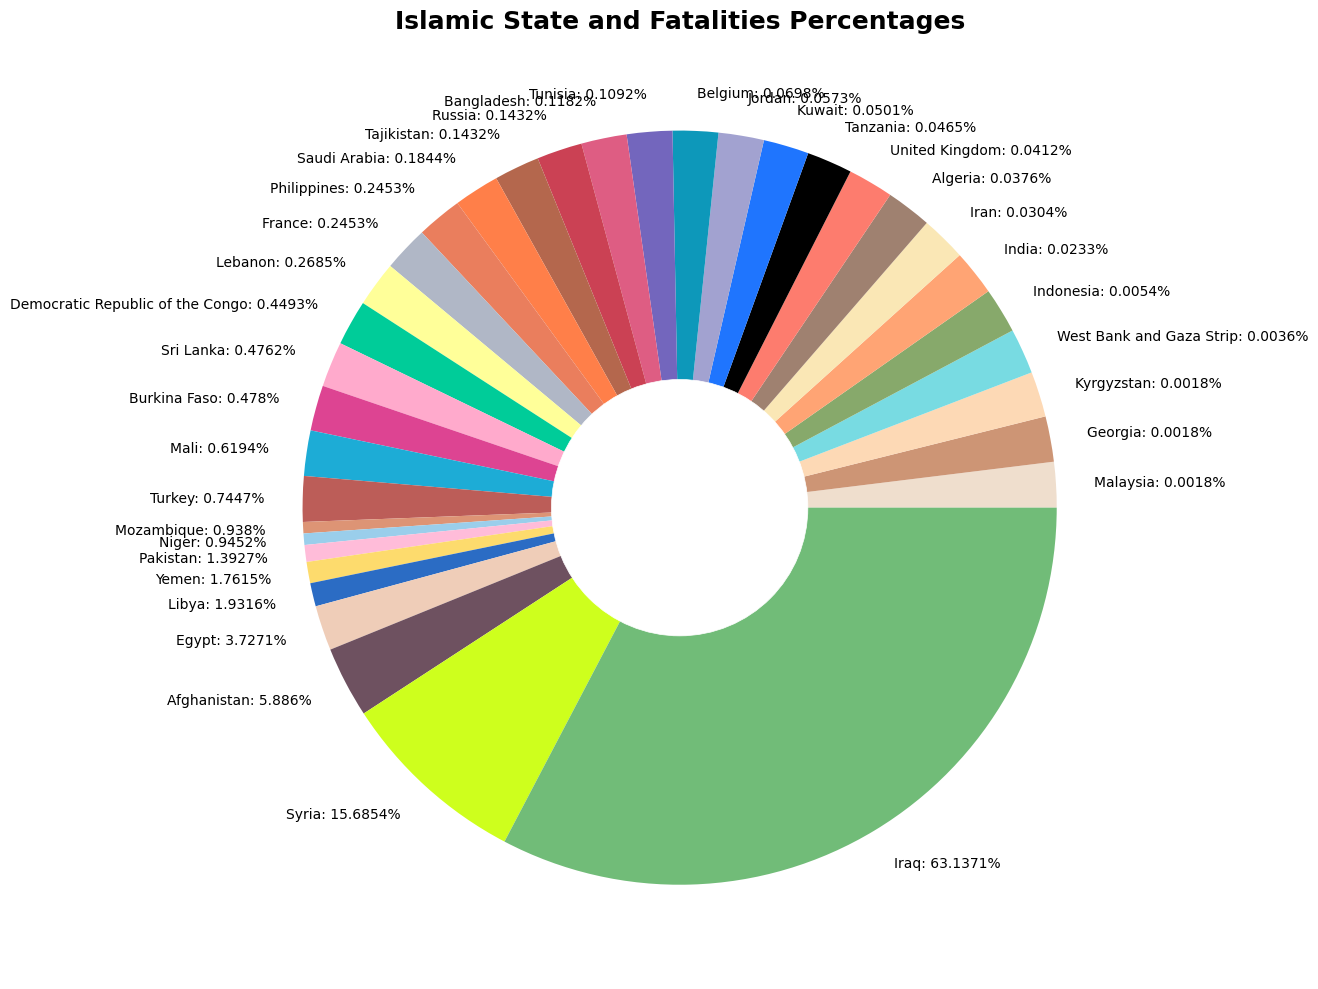

In [5]:
isis_df: 'DataFrame' = gtd.withColumn('islamic_state', get_gtd_islamic_state('gname')).filter("islamic_state == 'True' ")
isis_df = isis_df.withColumn('iyear', f.col('iyear').cast('integer'))
isis_df = isis_df.withColumn('nkill', f.col('nkill').cast('integer'))
isis_df = isis_df.withColumn('imonth', f.col('imonth').cast('integer'))
isis_df = isis_df.withColumn('iday', f.col('iday').cast('integer'))

isis_df = isis_df.withColumn('latitude', f.col('latitude').cast('double'))
isis_df = isis_df.withColumn('longitude', f.col('longitude').cast('double'))

total_fatalities: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in isis_df.groupBy('country_txt').agg(f.sum('nkill').alias('total_fatalities')).orderBy('total_fatalities').filter("total_fatalities > 0").collect() ] )
total_fatalities['percentages'] =  total_fatalities['total_fatalities'].apply(lambda row: round( (row/total_fatalities['total_fatalities'].sum()) * 100,4)  ).tolist()
countries, all_fatalities =zip(*total_fatalities.set_index('country_txt')['total_fatalities'].to_dict().items())

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot() 
ax.pie(x=[ 2100 if val < 500 else val for val in all_fatalities], labels=total_fatalities.apply(lambda row: "%s: %s%%" % (row['country_txt'], row['percentages']) ,axis=1).tolist(), colors=sns.crayon_palette( sns.crayons.keys()))
ax.set_title("Islamic State and Fatalities Percentages", fontweight='bold', fontsize=18)
plt.gcf().gca().add_artist(plt.Circle(radius=0.34, color='white', xy=(0,0) ))
plt.tight_layout() 

In [174]:
search_args: str = 'or '.join(total_fatalities.sort_values(by='total_fatalities', ascending=False).iloc[:11,:1]['country_txt'].apply(lambda row: "country_txt == '%s'" % (row)).tolist() )
df: 'DataFrame' = pd.DataFrame([ item.asDict() for item in isis_df.filter(search_args).filter("islamic_state == 'True' ").select('iyear', 'imonth', 'iday', 'country_txt', 'latitude', 'longitude', 'nkill').collect() ])
df['incident_date'] = pd.to_datetime( df.apply(lambda row: "%s-%s-%s" % (row['iyear'], row['imonth'], row['iday'] ) , axis=1 ) )


#### **Islamic State Ideology & Violence Operations around The World** 

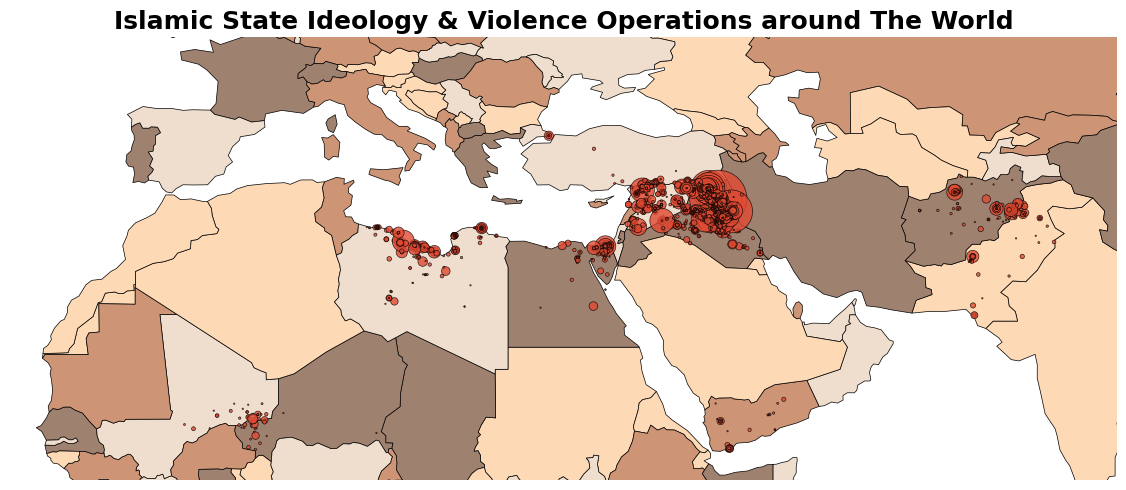

In [175]:
fig = plt.figure(figsize=(30,5)) # mostly operating in Syria/Iraq 
ax = fig.add_subplot()
gdf: 'GeoDataFrame' = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.longitude, df.latitude) )
world_map: 'GeoDataFrame' = gp.read_file(gp.datasets.get_path( gp.datasets.available[0]))
world_map.plot(ax=ax, ec='k', cmap=ListedColormap(sns.crayon_palette(['Almond', 'Antique Brass', 'Apricot', 'Beaver' ] )))
gdf.plot(ax=ax, markersize='nkill', ec='k', alpha=0.8 )
ax.set_title("Islamic State Ideology & Violence Operations around The World", fontweight='bold', fontsize=18)
ax.set_xlim([-20, 80])
ax.set_ylim([10, 50])
ax.axis('off') 
plt.tight_layout() 

#### **Islamic State Insurgency/ Violence Trends around The World** 

In [183]:
fig = plt.figure(figsize=(12,5))
for index,country in enumerate(['Iraq', 'Syria', 'Niger', 'Mali' ] ,1):
    ax = fig.add_subplot(2,2,index)
    df.query(f"country_txt == '{country}' ").groupby('incident_date')['nkill'].sum().replace({np.nan:0.0}).astype(int).resample('M').sum().interpolate().plot( ax=ax) 
    ax.set_title(f"ISIS Insurgency Trends in {country}", fontweight='bold', fontsize=14) # ISIS insurgency/trends in violence in Iraq 
    ax.set_ylabel("Total Fatalities")
plt.tight_layout() 

#### **IS OPS in Iraq vs. Syria**

In [193]:
iraq: STL = STL(df.query(f"country_txt == 'Iraq' ").set_index('incident_date')['nkill'].replace({np.nan:0}).astype(int) , period=12).fit()
syria: STL = STL(df.query(f"country_txt == 'Syria' ").set_index('incident_date')['nkill'].replace({np.nan:0}).astype(int) , period=12).fit()

In [202]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(2,2,1) 
syria.trend.plot(ax=ax) 
ax.set_title("Montly Fatalities Trends in Syria", fontweight='bold', fontsize=14)
ax.set_ylabel("Numbers of Fatalities")

ax = fig.add_subplot(2,2,2) 
syria.seasonal.plot(ax=ax) 
ax.set_title("Seasonal Montly Fatalities in Syria", fontweight='bold', fontsize=14)
ax.set_ylabel("Numbers of Fatalities")

ax = fig.add_subplot(2,2,3) 
iraq.trend.plot(ax=ax) 
ax.set_title("Montly Fatalities Trends in Iraq", fontweight='bold', fontsize=14)
ax.set_ylabel("Numbers of Fatalities")

ax = fig.add_subplot(2,2,4) 
iraq.seasonal.plot(ax=ax) 
ax.set_title("Seasonal Montly Fatalities in Iraq", fontweight='bold', fontsize=14)
ax.set_ylabel("Numbers of Fatalities")

plt.tight_layout() # there is fatalities cyclical pattern for ISIS ops in Syria (Aug - Dec) 

## **Africa Events**

In [4]:
africa_events: 'DataFrame' = odin_spark.read.format('parquet').load('s3a://worldevents/Africa/Africom/') # 2002 - 2024
africa_events = africa_events.withColumn('is_islamic_state', is_islamic_state('actor1')) # Islamic State activity in Africa Region, especially in Western Africa region

In [6]:
africa_events.printSchema() 

root
 |-- event_id_cnty: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- year: long (nullable = true)
 |-- time_precision: long (nullable = true)
 |-- disorder_type: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- sub_event_type: string (nullable = true)
 |-- actor1: string (nullable = true)
 |-- assoc_actor_1: string (nullable = true)
 |-- inter1: long (nullable = true)
 |-- actor2: string (nullable = true)
 |-- assoc_actor_2: string (nullable = true)
 |-- inter2: long (nullable = true)
 |-- interaction: long (nullable = true)
 |-- civilian_targeting: string (nullable = true)
 |-- iso: long (nullable = true)
 |-- region: string (nullable = true)
 |-- country: string (nullable = true)
 |-- admin1: string (nullable = true)
 |-- admin2: string (nullable = true)
 |-- admin3: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- geo_precision: lon

### **Islamic State Operation in Africa** 
- **Motive terrorist organization use HT to finance their organizations**
    - “Drug trafficking generates greater dollar revenues, but `trafficked women are far more profitable`. Unlike a drug, `a human female does not have to be grown, cultivated, distilled, or packaged`. Unlike a drug, a human female can be used by the customer again and again”[6].
 
- **According to an ISIL document below**
– released online and considered to be authentic –
fighters were required to pre-register if they wished to attend a slave market in Homs. In most cases, the sale was finalized through a bidding process. The offer was submitted in a sealed envelope at the time of purchase and the fighter who had won the bid was obliged to buy the slave [7].
- Women and girls were exposed, both at the slave markets and at the holding sites, as chattel. Interested buyers could check their hair or teeth and ask them to walk through the room, as if parading on a catwalk. [8] Their price was based on marital status, age, number of children and perceived beauty, and could range between $200 and $1,500.
[8] According to the 2015 FATF report on ISIL financing, the price paid for ISIL slaves was much lower, amounting, on average, to $13. Other sources110 report the following prices:

    - **0-9 years old**: $172
      
    - **10-20 years old**: $129
      
    - **20-30 years old**: $86
      
    - **30-40 years old**: $75.

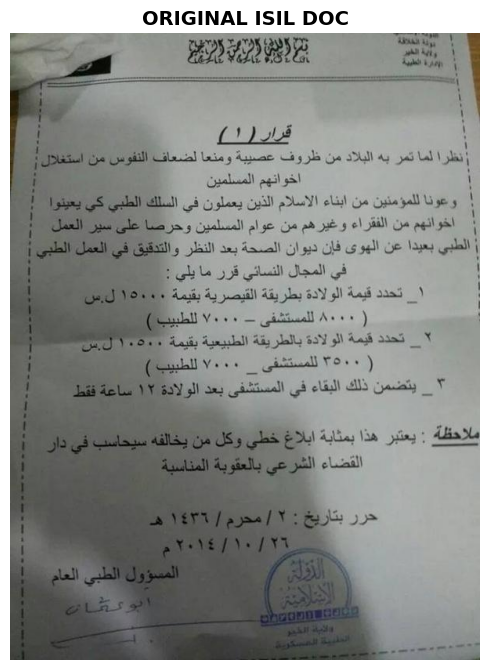

In [27]:
plt.rcParams['figure.figsize'] = (5,20)
plt.imshow(plt.imread("/mnt/odin_repo/ODIN_PROJECT/TaskForceODIN/images/isil_doc_human_slave_market.jpg")  )
plt.axis('off')
plt.title("ORIGINAL ISIL DOC", fontweight='bold', fontsize=14)
plt.tight_layout()

In [10]:
africa_events.filter("is_islamic_state == 'Yes' ").groupBy('region').count().orderBy('count',ascending=False).show() 

+---------------+-----+
|         region|count|
+---------------+-----+
| Western Africa| 6564|
|  Middle Africa| 3548|
|Northern Africa| 1558|
| Eastern Africa|  121|
+---------------+-----+



### **Other FTOs operating in Africa**
<img src="https://www.dni.gov/nctc/img/groups/jnim_flag_oct2022.jpg">
<br>

- **Total Fatalities involving JNIM**: Jama’at Nusrat al-Islam wal-Muslimin 

In [41]:
other_fto: 'Series' = pd.Series( africa_events.select("actor1").rdd.flatMap(lambda x: x).collect() ) 
search_payload: str = ' or '.join(pd.Series(other_fto.apply(lambda row: row if 'JNIM' in row else np.nan).dropna().unique() ).apply(lambda row: "actor1 == '%s'" % row ).tolist() )
africa_events.filter(search_payload).groupBy("year").pivot("region").agg(f.sum('fatalities').alias('total_fatalities') ).withColumnRenamed('Western Africa', 'Total Fatalities Western Africa').orderBy('year').show() 

+----+-------------------------------+
|year|Total Fatalities Western Africa|
+----+-------------------------------+
|2017|                            189|
|2018|                            426|
|2019|                           1087|
|2020|                           1456|
|2021|                           1313|
|2022|                           3175|
|2023|                           5825|
|2024|                           5050|
+----+-------------------------------+



### **Other FTOs** 
- Combination between Boko Haram, ISIS-West Africa Region, and JNIM

In [38]:
search_payload: str = 'or '.join( pd.Series( pd.Series(other_fto).apply(lambda row: row if 'Boko Haram' in row else np.nan).dropna().unique()).apply(lambda row: "actor1 == '%s' " % (row) ).tolist())
africa_events.filter(search_payload).groupBy('region').agg( f.sum('fatalities').alias('total_fatalities')) .show() 

+--------------+----------------+
|        region|total_fatalities|
+--------------+----------------+
|Western Africa|           16836|
| Middle Africa|            5849|
+--------------+----------------+



### **HT Victims in Africa Region** 
- According to the ISIS-Doc above, juvenile HT victims have the highest price of `172 US Dollar` for age between 0 - 9 and `129 US Dollar` for age between 10 and 20 years old.
- Boko Haram and ISIS-West Africa are responsible for smuggling HT Victim to finance their terrorist operations.
    - ISIS-West Africa conducts their operation throughout the Lake Chad Basin region of Cameroon, Chad, Niger, and Nigeria. Also, the organization receives funding from ISIS core and local revenue sources, including kidnappings-for-ransom, taxation, and extortion. 
- Most HT victim are forced into labor or sold as a slave/prostitute.
    - `17.45%` HT Victims from Africa region endup in Western Europe as `sex workers`.
    - `21.64%` HT Victims from Africa region endup in Northern Europe as `sex workers`. 

In [77]:
africa_countries: List[str] = africa_events.select('country').distinct().rdd.flatMap(lambda x: x).collect() 
ht_df: 'DataFrame' = pd.read_excel("s3://worldevents/HumanTrafficking/data_glotip.xlsx", sheet_name='data_glotip_1')
ht_df.columns = ht_df.iloc[1].tolist()
ht_df = ht_df.iloc[2:]
ht_df['value'] = ht_df['txtVALUE'].astype(str).apply(lambda row: 4 if row == '<5' else int( row.replace(',','').strip()) if ',' in row else int(row) )  
ht_victims_af: List[str] = list(set(africa_countries) & set( ht_df[ ht_df['Indicator'].isin(['Detected trafficking victims'])].query("Dimension == 'by citizenship' ")['Category'].sort_values().unique()))
ht_df.index = np.arange(1, ht_df.shape[0] + 1) 

In [78]:
ht_df.head() 

Iso3_code      Country    Region                        Subregion  \
1       ABW        Aruba  Americas  Latin America and the Caribbean   
2       AFG  Afghanistan      Asia                    Southern Asia   
3       AFG  Afghanistan      Asia                    Southern Asia   
4       AFG  Afghanistan      Asia                    Southern Asia   
5       AFG  Afghanistan      Asia                    Southern Asia   

                             Indicator                   Dimension Category  \
1         Detected trafficking victims  by country of repatriation  Ukraine   
2         Detected trafficking victims  by country of repatriation   Abroad   
3         Detected trafficking victims  by country of repatriation   Abroad   
4   Offences of trafficking in persons                       Total    Total   
5  Persons brought into formal contact                       Total    Total   

     Sex    Age  Year Unit of measurement txtVALUE  Source  value  
1  Total  Total  2010              Counts       <5  GLOTIP      4  
2  Total  Total  2003              Counts       <5  GLOTIP      4  
3  Total  Total  2008              Counts       <5  GLOTIP      4  
4  Total  Total  2013              Counts      103  GLOTIP    103  
5  Total  Total  2013              Counts      167  GLOTIP    167

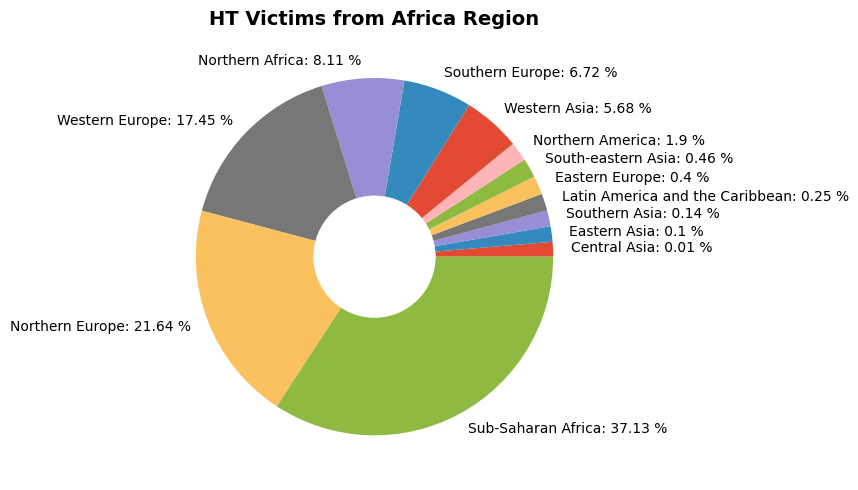

In [103]:
af_subregion, total_vic = zip(*ht_df[ht_df['Category'].isin(ht_victims_af)].groupby('Subregion')['value'].sum().sort_values().to_dict().items() ) 

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.pie(x=[ vic + 500 if vic < 500 else vic  for vic in total_vic], labels=[ "%s: %s %%" % (subregion, round( (total/sum(total_vic) ) * 100, 2) ) for subregion,total in zip(af_subregion, total_vic)] )
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), radius=0.34, color='white'))
ax.set_title("HT Victims from Africa Region", fontweight='bold', fontsize=14)
plt.tight_layout() #

### **Sexual Exploitation HT Victims in Sub-Saharan Africa Region** 
- Especially in Nigeria because ISIS-West Africa were mainly operating in northeastern Nigeria.

In [149]:
payload: str = "Indicator == 'Detected trafficking victims' and (Age == '0 to 17 years' or Age == '18 years or over' ) and Subregion == 'Sub-Saharan Africa' and Category == 'Sexual exploitation' and (Sex == 'Female' or Sex == 'Male') "
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(2,2,1)
ht_df.query("Country == 'Nigeria' and Indicator == 'Detected trafficking victims' and Dimension == 'Total' and Age == '0 to 17 years' and Sex == 'Female' ").groupby('Year')['value'].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Underage Female HT Victim from Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of HT Victims")

ax = fig.add_subplot(2,2,2)
ht_df.query("Country == 'Nigeria' and Indicator == 'Detected trafficking victims' and Dimension == 'Total' and Age == '0 to 17 years' and Sex == 'Male' ").groupby('Year')['value'].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Underage Male HT Victim from Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of HT Victims")

ax = fig.add_subplot(2,2,3)
ht_df.query("Country == 'Nigeria' and Indicator == 'Detected trafficking victims' and Dimension == 'Total' and Age == '18 years or over' and Sex == 'Female' ").groupby('Year')['value'].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Adult Female HT Victim from Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of HT Victims")

ax = fig.add_subplot(2,2,4)
ht_df.query("Country == 'Nigeria' and Indicator == 'Detected trafficking victims' and Dimension == 'Total' and Age == '18 years or over' and Sex == 'Male' ").groupby('Year')['value'].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Adult Male HT Victim from Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of HT Victims")

plt.tight_layout() 

### **Known Perpetrators Operating in West Africa** 
- Known Terrorist Organization Operating in `West Africa`
    - JNIM: Group for Support of Islam and Muslims
    - Islamic State (West Africa)


In [4]:
africa_regions: List[str] = africa_events.select('region').distinct().rdd.flatMap(lambda x: x).collect() 
west_africa: "DataFrame" = pd.DataFrame([ item.asDict() for item in africa_events.filter("region == 'Western Africa' ").collect() ] )

# Known FTOs operating in Africa 
KNOWN_FTOs: List[str] = west_africa['actor1'].apply(lambda row: row if FTO_AFRICA[0] in row.lower() or FTO_AFRICA[1] in row.lower()  or FTO_AFRICA[2] in row.lower()  or FTO_AFRICA[3] in row.lower() else np.nan  ).dropna().unique().tolist()  

In [22]:
west_africa[west_africa['actor1'].isin(KNOWN_FTOs) ].groupby(['year','actor1']).size().unstack('year').replace({np.nan:0}).astype(int).sort_values(by=list(range(2015, 2025)), ascending=False) 

year                                                                                                             2015  \
actor1                                                                                                                  
Islamic State (West Africa)                                                                                       184   
Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad                         0   
Islamic State (Greater Sahara)                                                                                      0   
JNIM: Group for Support of Islam and Muslims                                                                        0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (Greater Sahara)                                  0   
Islamic State (Greater Sahara) and/or Ansaroul Islam                                                                0   
Islamic State (West Africa) - Greater Sahara Faction                                                                0   
Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad     0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (West Africa) - Greater Sahara Faction            0   
Islamic State (West Africa) - Lake Chad Faction                                                                     0   
Islamic State (Sahel)                                                                                               0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)                                           0   

year                                                                                                             2016  \
actor1                                                                                                                  
Islamic State (West Africa)                                                                                        72   
Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad                        32   
Islamic State (Greater Sahara)                                                                                      4   
JNIM: Group for Support of Islam and Muslims                                                                        0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (Greater Sahara)                                  0   
Islamic State (Greater Sahara) and/or Ansaroul Islam                                                                0   
Islamic State (West Africa) - Greater Sahara Faction                                                                0   
Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad     0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (West Africa) - Greater Sahara Faction            0   
Islamic State (West Africa) - Lake Chad Faction                                                                     0   
Islamic State (Sahel)                                                                                               0   
JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)                                           0   

year                                                                                                             2017  \
actor1                                                                                                                  
Islamic State (West Africa)                                                                                        12   
Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad                       139   
Islamic State (Greater Sahara)                                                                                      6   
JNIM:

### **Islamic State Operations in West Africa**

In [36]:
# Finance tied to HT 
islamic_state_af: 'DataFrame' = west_africa[ west_africa['actor1'].apply(lambda row:  FTO_AFRICA[1].lower() in row.lower() ) ]
islamic_state_af['event_date'] = pd.to_datetime( islamic_state_af['event_date'] )
islamic_state_af['month'] = islamic_state_af['event_date'].apply(lambda row: row.month) 
islamic_state_af['month_name'] = islamic_state_af['event_date'].apply(lambda row: row.month_name() ) 
islamic_state_af.groupby([ 'year', 'event_type' ]).size().unstack('year') 

year                        2015  2016  2017  2018  2019  2020  2021  2022  \
event_type                                                                   
Battles                       14    42    20   109   228   433   255   341   
Explosions/Remote violence    61    22    49    46    59    99   101    76   
Strategic developments         5     4     9    33    87   175   182   372   
Violence against civilians   104    40    79   135   327   483   355   441   

year                        2023  2024  
event_type                              
Battles                      301   134  
Explosions/Remote violence   108    90  
Strategic developments       307   198  
Violence against civilians   415   225

### **Islamic State Violence Trends in West Africa**
- **Organization Goal**:
    - Discredit regional governments 
    - Replace the current government system with ISIS-style state and ideology
- **Tactics / Possible Motive**:
    - ISIS - West Africa employ tactics such as ambushes, military-style assults, roadside bombs, kidnappings, and targeted killings.
    - The group focuses most of its attacks on regional military and civilian defense forces.
    - **Undermining local government**:
        - Disrupt local election
        - Kill/Assassinate local government official 
    - Exploits poor economic conditions / social divisions to recruit its member.
 
- **Targets**
    - Government personnel and infrastructure.
    - Foreign aid workers
    - Christians
    - Other civilians whom it perceives as working against the group or opposing its interpertation of Islamic law.
 
- **Weapons**
    - Small arms
    - Light and Heavy machine guns
    - Vehicle-mounted weapons,
    - RPG (Rocket-propelled grenades)
    - Mines
    - Rockets (Mortar Family)
    - IED (Improvised Explosive Device)
      
- **Trends in Violence**
  - **Nigeria**: Spike in violence in 2022
  - **Mali**:

- **Organization Fundings**
    - Human Trafficking / Smuggling Weapons/Drugs
    - Kidnapping for ransom
    - Extortion
    - Roberry / Looting 
    - Donation / Abuse of non-profit organization
    - Cattle/Livestock Rustling
    - Local Business/Commercial Enterprises (Front Company that supports FTOs)

In [166]:
fig = plt.figure(figsize=(20,10))

for index,country in enumerate(islamic_state_af['country'].unique()[:5] , 1):
    ax = fig.add_subplot(3,2,index)
    islamic_state_af.query(f"country == '{country}' ").groupby(['event_date'])['fatalities'].sum().plot() 
    ax.set_title(f"Trends in Violence involving Islamic State in {country}", fontweight='bold', fontsize=14)
    ax.set_ylabel("Number of Fatalities")

plt.tight_layout() 

### **Violence Trends in Nigeria**

In [165]:
islamic_state_af.query("country == 'Nigeria' ").groupby(['event_type', 'year'])['fatalities'].sum().unstack('year').replace({np.nan:0}).astype(int) 

year                        2015  2016  2017  2018  2019  2020  2021  2022  \
event_type                                                                   
Battles                        0    43   114   431   791  1217   859   660   
Explosions/Remote violence  1198   250   346   243    61   175   235    87   
Strategic developments         3     0     5     2     7     0     0     0   
Violence against civilians  1319   308   441   238   217   407   137   241   

year                        2023  2024  
event_type                              
Battles                      877   230  
Explosions/Remote violence   179   157  
Strategic developments         0     6  
Violence against civilians   153   175

### **Boko Haram and Political Violence in Nigeria** 
- Boko Haram has been operating in northern Nigeria since 2003 and demand full adoption of Sharia law in northern Nigeria.
- In 2009, the group launced an insurgency from northern Nigeria, which spread to the borders of Niger, Chad, and Cameroon.
- In 2013, the Nigerian government declared Boko Haram and its affiliates terrorist organizations and joined forced with neighboring countries (Niger and Chad) to reclaim territory taken by the group.

#### **Former Boko Haram Leader (2009 to 2021)**
<b>Abubakar Shekau  [DECEASED]</b><br><img src="https://www.dni.gov/nctc/img/groups/leader_boko_haram_abubakar_shekau.jpg" width="150px" >

#### **Elected President of Nigeria from 2015 - 2023 (Muhammadu Buhari)** 
- **First Term**: May 29,2015 - May 29,2019
- **Second Term**: May 29, 2019 - May 29, 2023

In [66]:
nigeria_df: 'DataFrame' = africa_events.filter("country == 'Nigeria' ")
nigeria_actors: List[str] = nigeria_df.select('actor1').rdd.flatMap(lambda x: x).collect() 
nigeria_df = nigeria_df.withColumn('nigeria_perps', get_nigerian_actors('actor1'))
nigeria_df = nigeria_df.withColumn('is_boko_haram', find_boko_haram_nigeria('actor1'))

boko_haram: 'DataFrame' = pd.DataFrame([ item.asDict() for item in nigeria_df.filter("is_boko_haram == 'True' and ( disorder_type == 'Political violence' or disorder_type == 'Political violence; Demonstrations')  ").collect() ])
boko_haram['event_date'] = pd.to_datetime( boko_haram['event_date'])
boko_haram['sub_event_type_encoded'] = pd.factorize(boko_haram['sub_event_type'])[0]
boko_haram['month'] = boko_haram['event_date'].apply(lambda row: row.month) 

In [6]:
nigeria_df.printSchema() 

root
 |-- event_id_cnty: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- year: long (nullable = true)
 |-- time_precision: long (nullable = true)
 |-- disorder_type: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- sub_event_type: string (nullable = true)
 |-- actor1: string (nullable = true)
 |-- assoc_actor_1: string (nullable = true)
 |-- inter1: long (nullable = true)
 |-- actor2: string (nullable = true)
 |-- assoc_actor_2: string (nullable = true)
 |-- inter2: long (nullable = true)
 |-- interaction: long (nullable = true)
 |-- civilian_targeting: string (nullable = true)
 |-- iso: long (nullable = true)
 |-- region: string (nullable = true)
 |-- country: string (nullable = true)
 |-- admin1: string (nullable = true)
 |-- admin2: string (nullable = true)
 |-- admin3: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- geo_precision: lon

#### **Boko Haram Violence Tactics** 

In [63]:
pd.DataFrame( boko_haram.groupby('sub_event_type')['fatalities'].sum().sort_values(ascending=False) )

fatalities
sub_event_type                                 
Attack                                     9275
Armed clash                                3056
Suicide bomb                               1871
Remote explosive/landmine/IED              1284
Non-state actor overtakes territory          66
Shelling/artillery/missile attack            54
Sexual violence                              32
Grenade                                      14
Abduction/forced disappearance                0
Air/drone strike                              0
Government regains territory                  0

#### **Total Fatalities in Nigeria from 2009 - 2024 involving by Boko Haram**

In [48]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
sns.heatmap(pd.pivot_table(data=boko_haram, columns='month', index='year', values='fatalities', aggfunc='sum').replace({np.nan:0}).astype(int).rename(dict(map(lambda item: (item[1], item[0]) , MONTH_LOOKUP.items())), axis=1), 
            annot=True,
            fmt='',
            ax=ax) 

ax.set_title("Total Fatalities in Nigeria from 2009 - 2024 involving by Boko Haram", fontweight='bold', fontsize=14)
plt.tight_layout()

#### **Boko Haram: Distribution of Civilian Fatalities**

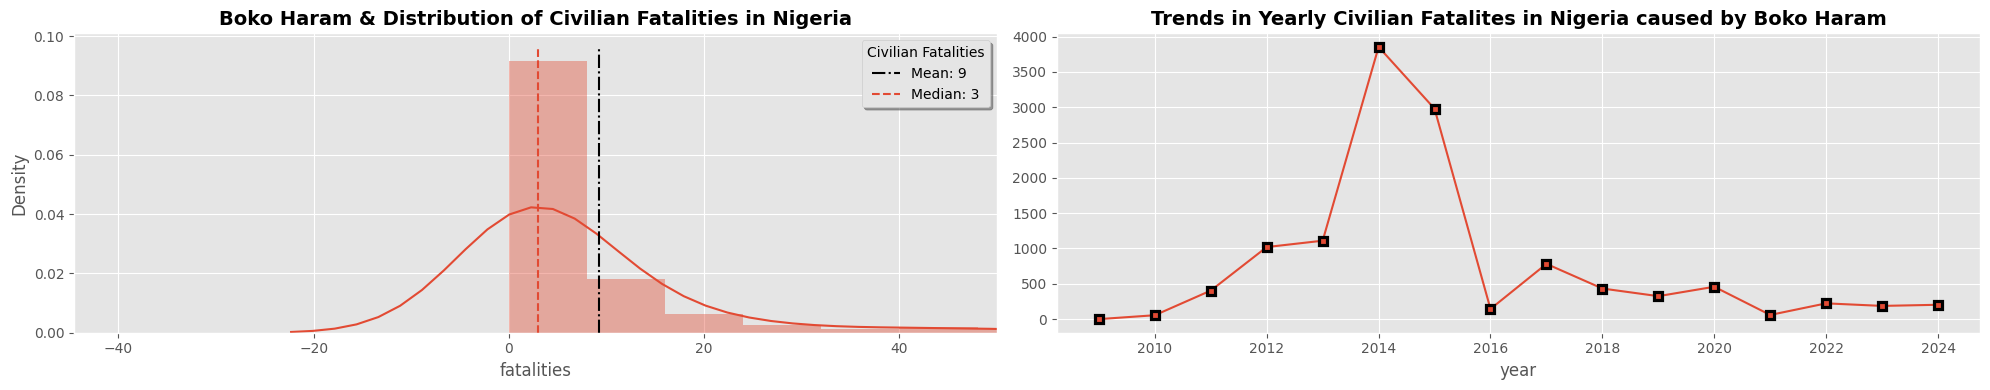

In [58]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,2,1)

civilian_fatalities: 'DataFrame' = boko_haram.query("civilian_targeting == 'Civilian targeting' ")['fatalities'] 
sns.distplot( civilian_fatalities, ax=ax)

mean: float = civilian_fatalities.mean() 
median: float = civilian_fatalities.median() 

ax.set_title("Boko Haram & Distribution of Civilian Fatalities in Nigeria", fontweight='bold', fontsize=14)
xmin,xmax = ax.get_xlim() 
ymin,ymax = ax.get_ylim() 
ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.0f}", linestyle='-.', color='black' ) 
ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.0f}", linestyle='--' ) 

ax.set_xlim([xmin,50])
ax.legend(title="Civilian Fatalities", fancybox=True, shadow=True)

ax = fig.add_subplot(1,2,2)
boko_haram.query("civilian_targeting == 'Civilian targeting' ").groupby('year')['fatalities'].sum().plot(marker='s', mec='black', mew=2.3, ax=ax)
ax.set_title("Trends in Yearly Civilian Fatalites in Nigeria caused by Boko Haram", fontweight='bold', fontsize=14)

plt.tight_layout()

#### **Boko Haram Crimes (2009 - 2024)** 
- **April 14,2014**: Boko Haram kidnpaped 276 female students from the Government Secondary School in the town of Chibok in Borno State, Nigeria. Here  the nexus with human trafficking is clear. Because most captive were complled to convert, subjected to domestic servitude, forced labor, sexual slavery, and used as suicide bombers in military operations.
- **March 7, 2015**: Boko Haram pledges allegiance to ISIS (Iraq and Syria) and becomes ISIS-West Africa (`Wilayat Gharb Afriqiyya`) <--> (`Abu Bakr al-Baghdadi`) blows up Iraqi Army Headquarters north of Ramadi (Killing approx 40 Iraqi Soldiers) on `March 12, 2015`.

In [95]:
fig = plt.figure(figsize=(20,4))
plt.imshow( plt.imread("/mnt/odin_repo/ODIN_PROJECT/TaskForceODIN/images/14042014BokoHaramIncident.png") )
plt.axis('off')

plt.title("April 14, 2014: 276 School Girls Abducted by Boko Haram", fontweight='bold', fontsize=14)
plt.tight_layout()

#### **Boko Haram and Civilian Fatalities After Pledging Allegiance to ISIS (Iraq/Syria)**

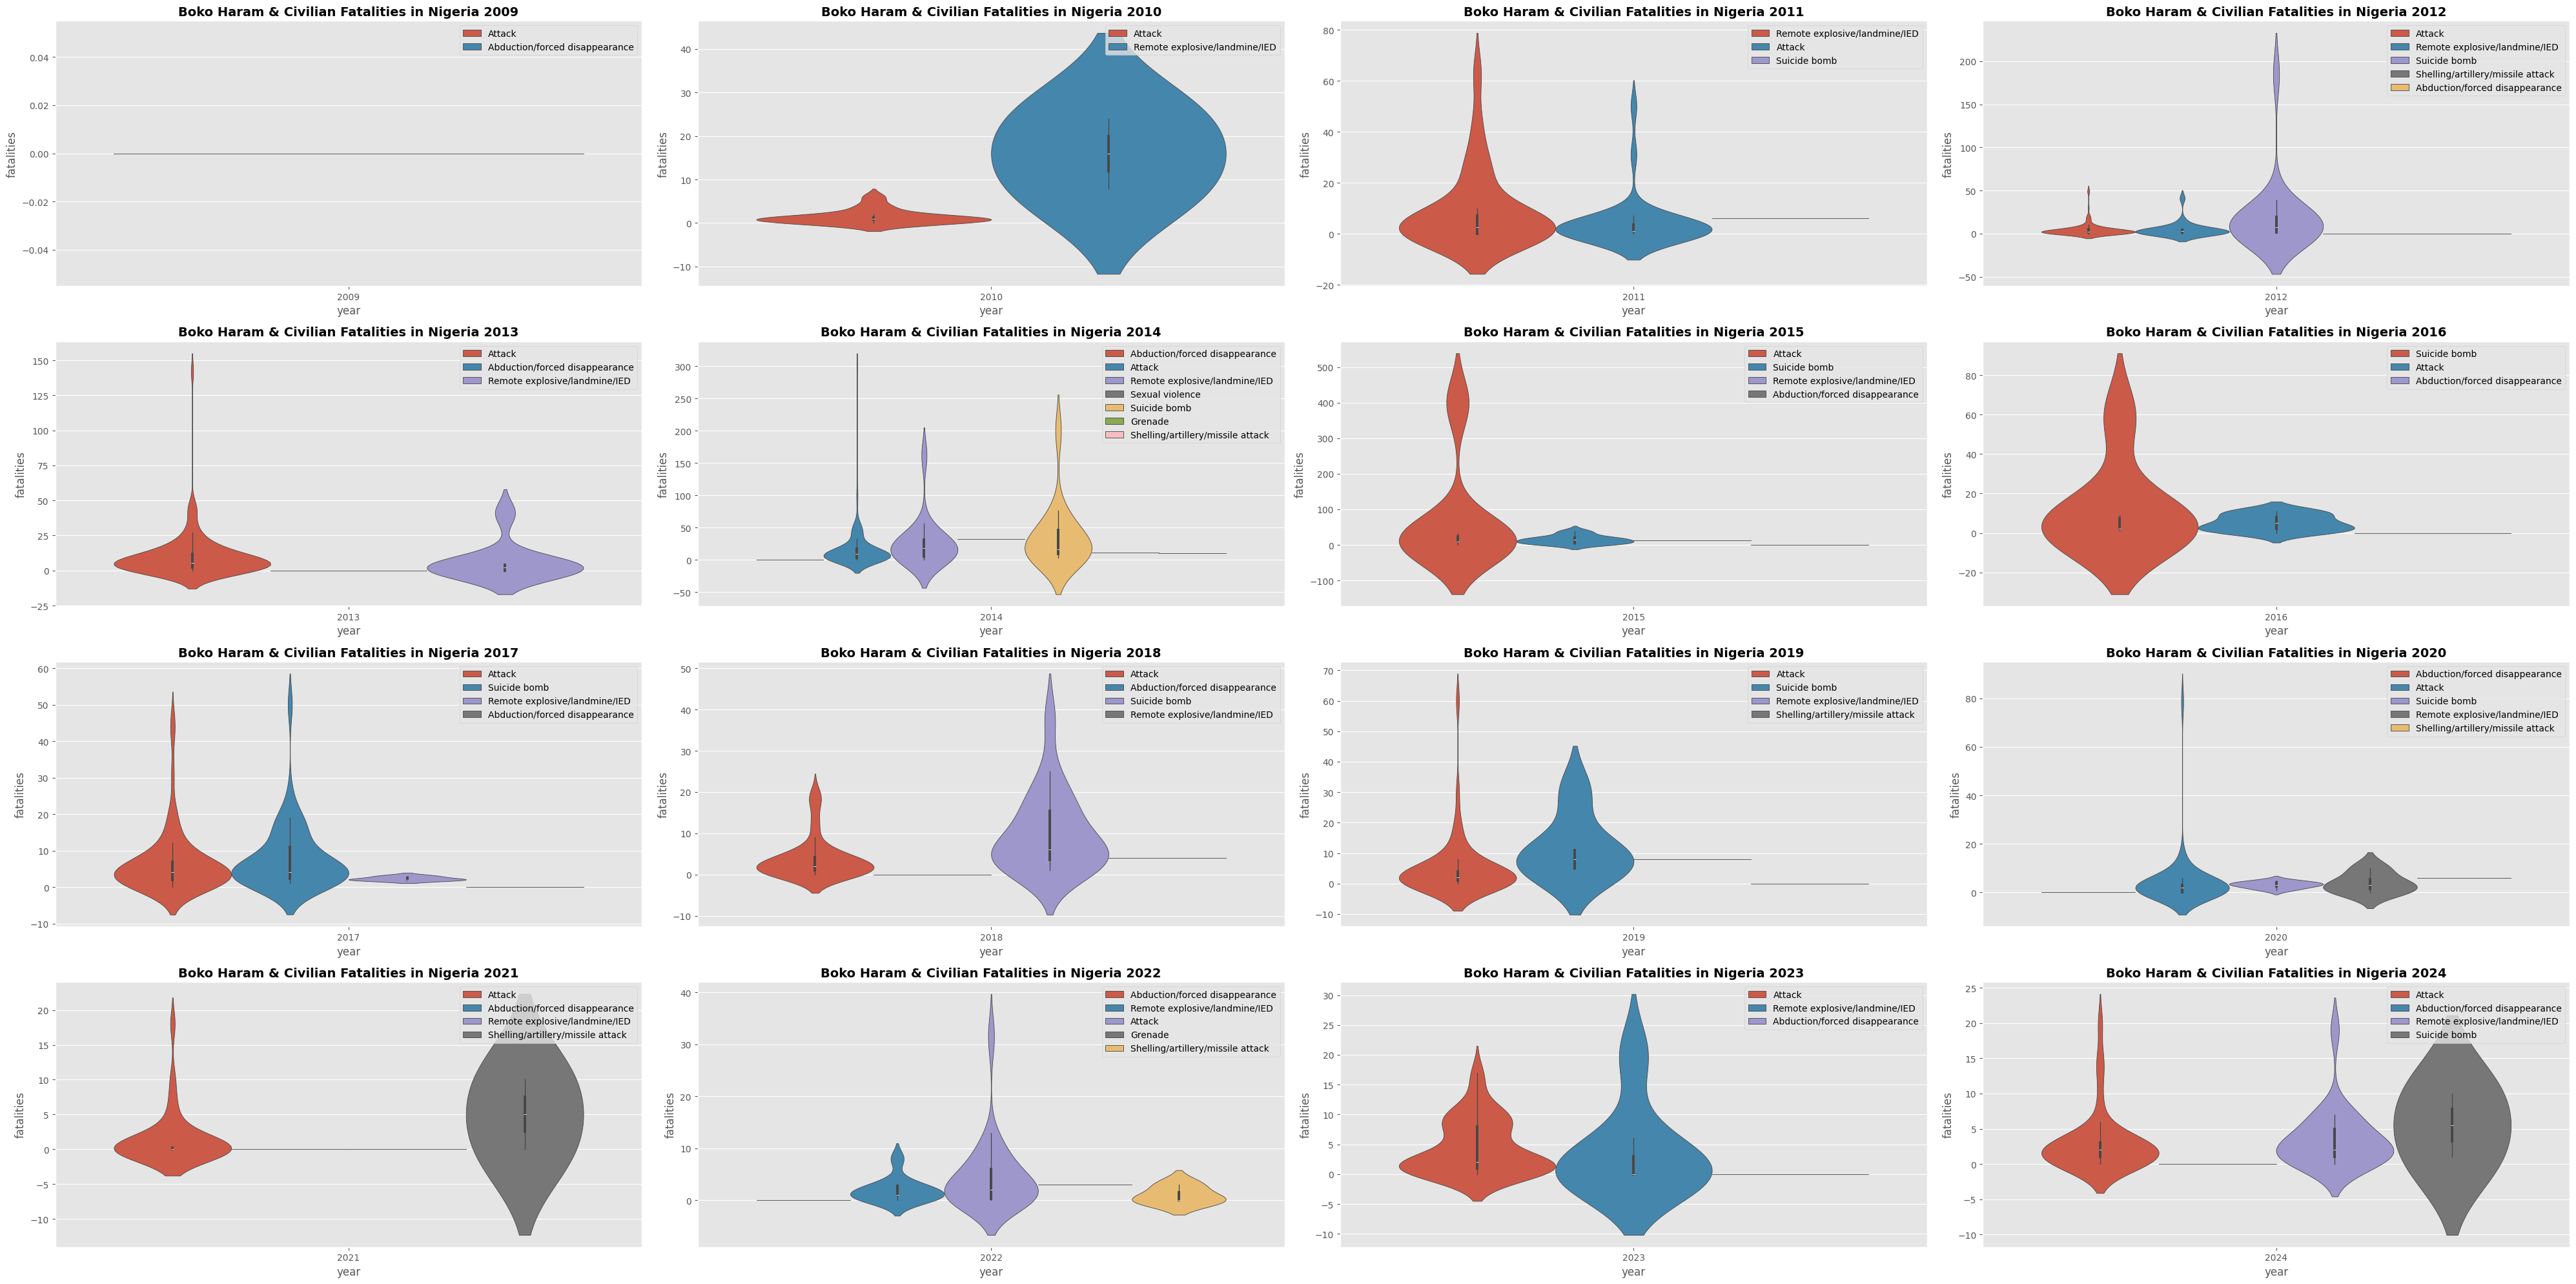

In [115]:
warnings.filterwarnings(action='ignore', message='INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.')
fig = plt.figure(figsize=(40,20))

for index,year in enumerate(boko_haram['year'].sort_values().unique(), 1):
    ax = fig.add_subplot(4,4,index) 
    sns.violinplot(data=boko_haram.query(f"civilian_targeting == 'Civilian targeting' and year == {year} "), x='year', y='fatalities', hue='sub_event_type', ax=ax)
    ax.set_title(f"Boko Haram & Civilian Fatalities in Nigeria {year}", fontweight='bold', fontsize=14)
    ax.legend(bbox_to_anchor=(1,1))
plt.tight_layout() 

In [117]:
fatalities_summary: 'DataFrame' = pd.DataFrame( boko_haram.query("(year >= 2014 and year <=2015)").groupby(['admin1'])['fatalities'].sum().sort_values(ascending=False) )
fatalities_summary

fatalities
admin1                               
Borno                            5310
Adamawa                           426
Yobe                              370
Kano                              281
Plateau                           205
Federal Capital Territory         100
Zamfara                           100
Kaduna                             89
Bauchi                             55
Gombe                              53
Jigawa                              0

In [123]:
fig = plt.figure(figsize=(20,10)) 

for index,state in enumerate(fatalities_summary.index[:4], 1):
    ax = fig.add_subplot(2,2,index)
    boko_haram.query(f"(year >= 2014 and year <=2015)  and civilian_targeting == 'Civilian targeting' and admin1 == '{state}' ").set_index('event_date')['fatalities'].resample("W").mean().replace({np.nan:0}).astype(int).interpolate().plot(ax=ax)
    ax.set_title(f"Civilian Fatalities in {state}, Nigeria between 2014 - 2015", fontweight='bold', fontsize=14)

plt.tight_layout() 

#### **Boko Haram Fatalities Trends in Nigeria** 

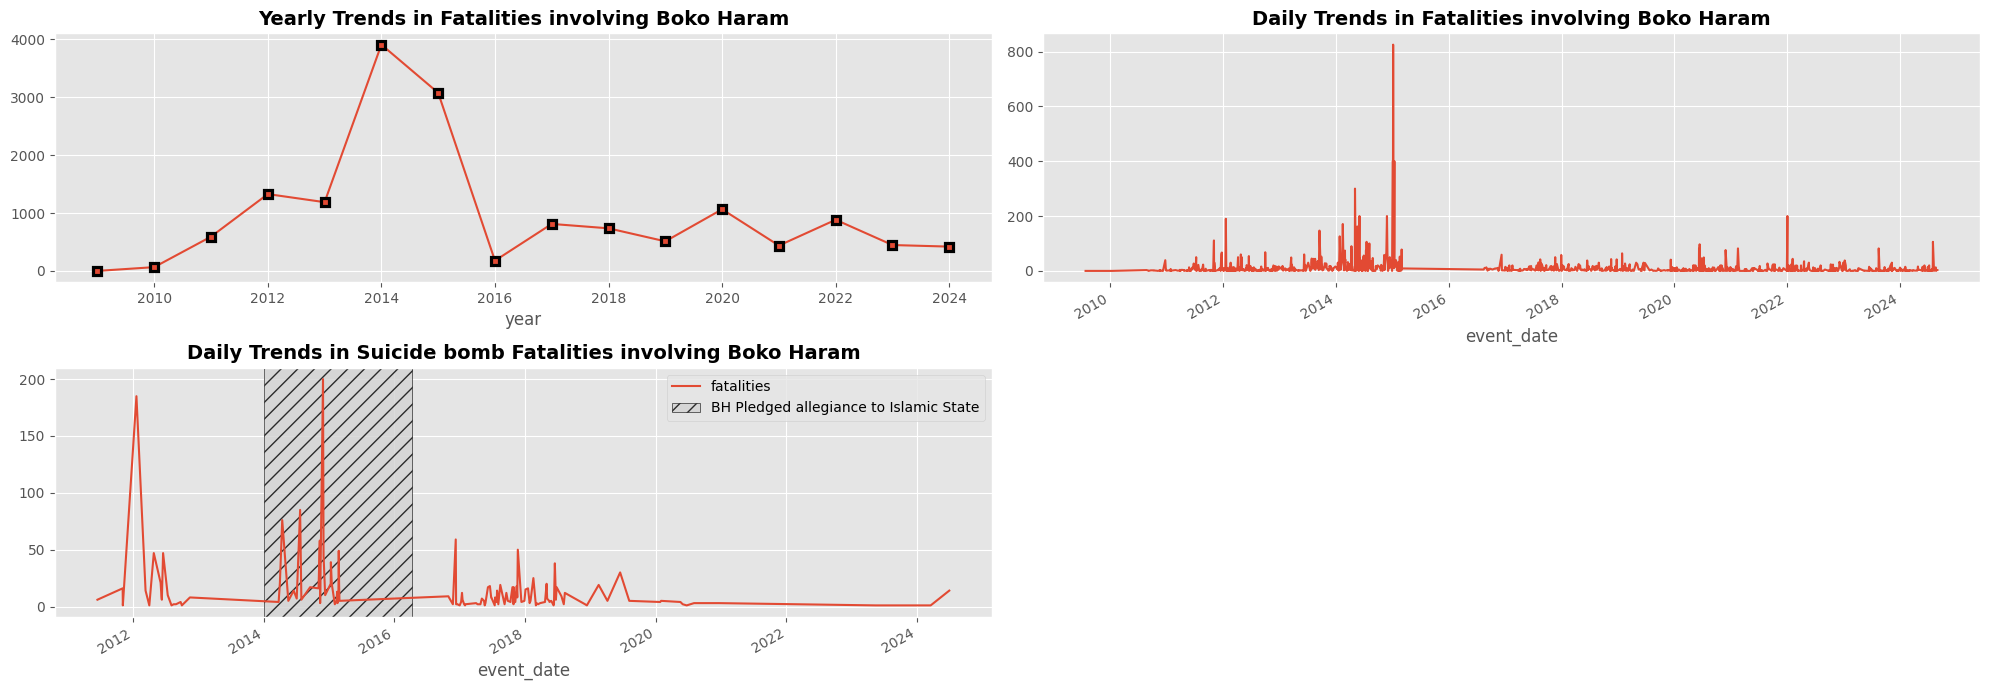

In [77]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(2,2,1)
boko_haram.groupby('year')['fatalities'].sum().plot(ax=ax, marker='s', mec='black', mew=2.3)
ax.set_title("Yearly Trends in Fatalities involving Boko Haram", fontweight='bold', fontsize=14)

ax = fig.add_subplot(2,2,2)
boko_haram.groupby('event_date')['fatalities'].sum().plot(ax=ax) 
ax.set_title("Daily Trends in Fatalities involving Boko Haram", fontweight='bold', fontsize=14)

ax = fig.add_subplot(2,2,3)
boko_haram.query("sub_event_type == 'Suicide bomb' ").groupby('event_date')['fatalities'].sum().plot(ax=ax) 
ax.set_title("Daily Trends in Suicide bomb Fatalities involving Boko Haram", fontweight='bold', fontsize=14)
ax.axvspan(xmin=16071, xmax=16900, hatch='//', ec='k', alpha=0.8, fc='lightgrey', label="BH Pledged allegiance to Islamic State")
ax.legend() 
plt.tight_layout() #  BH pledged allegiance to ISIS (2015)

#### **Boko Haram Area of Operation in Nigeria**

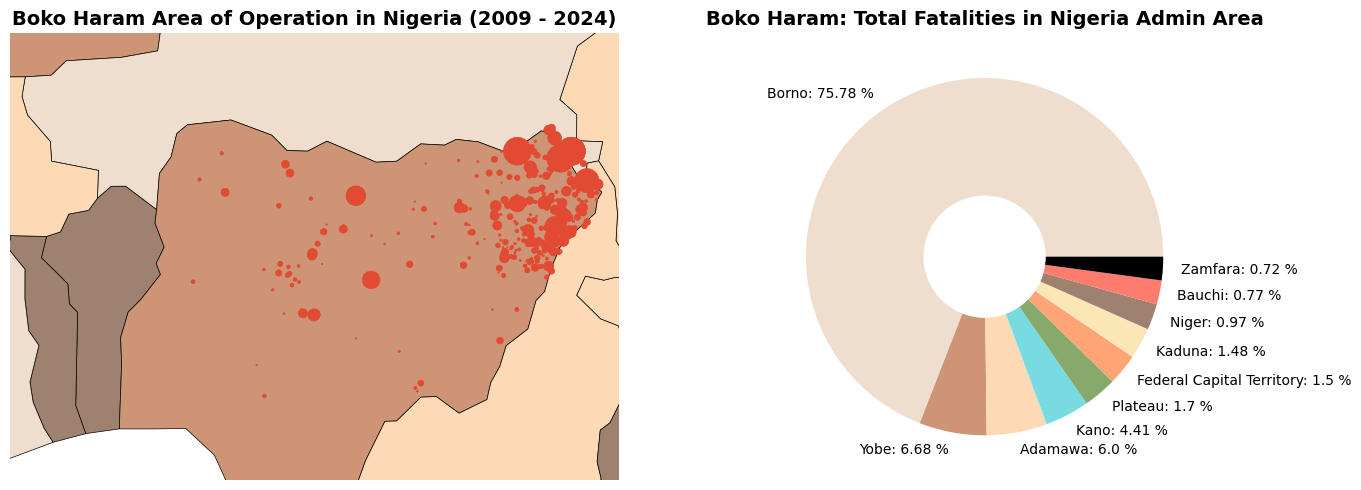

In [143]:
gdf: 'GeoDataFrame' = gp.GeoDataFrame(boko_haram, geometry=gp.points_from_xy(x=boko_haram.longitude, y=boko_haram.latitude))
world_map: 'GeoDataFrame' = gp.read_file(gp.datasets.get_path(gp.datasets.available[0]))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
world_map.query("continent == 'Africa' ").plot(color='white', ec='black', ax=ax, cmap=ListedColormap(sns.crayon_palette( ['Almond', 'Antique Brass', 'Apricot', 'Beaver'] )) )
ax.axis('off') 
gdf.plot(ax=ax, markersize='fatalities')
ax.set_title("Boko Haram Area of Operation in Nigeria (2009 - 2024)", fontweight='bold', fontsize=14)
ax.set_ylim([5,16])
ax.set_xlim([0,15])
ax.grid(True) 

ax = fig.add_subplot(1,2,2)
admin, total_fatalities = zip(*boko_haram.groupby('admin1')['fatalities'].sum().sort_values(ascending=False).head(10).to_dict().items())
ax.pie(x=[ val + 250 if val < 500 else val for val in total_fatalities], labels=[ "%s: %s %%" % (item[0], round( (item[1]/sum(total_fatalities) ) * 100, 2) ) for item in zip(admin, total_fatalities)], colors=sns.crayon_palette(sns.crayons.keys() ) )
ax.set_title("Boko Haram: Total Fatalities in Nigeria Admin Area", fontweight='bold', fontsize=14)
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), color='white', radius=0.34))
plt.tight_layout() 

#### **Boko Haram Targets in Nigeria** 

In [5]:
bh_df: 'DataFrame' = gtd.filter("gname == 'Boko Haram' ")
countries: List[str] = bh_df.select('country_txt').distinct().rdd.flatMap(lambda x: x).collect()
nigeria_bh_df: 'DataFrame' = bh_df.filter("country_txt == 'Nigeria' ")
nigeria_bh_df = nigeria_bh_df.withColumn('nkill', f.col('nkill').cast('integer'))

nigeria_targets: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in nigeria_bh_df.groupBy('targtype1_txt').agg( f.sum('nkill').alias('total_fatalities') ).na.fill(0).orderBy('total_fatalities').collect() ] )
nigeria_targets = nigeria_targets.query("total_fatalities > 15 ")
nigeria_targets['percentage'] = nigeria_targets['total_fatalities'].apply(lambda row: round( (row / nigeria_targets['total_fatalities'].sum()) * 100 ,2) )

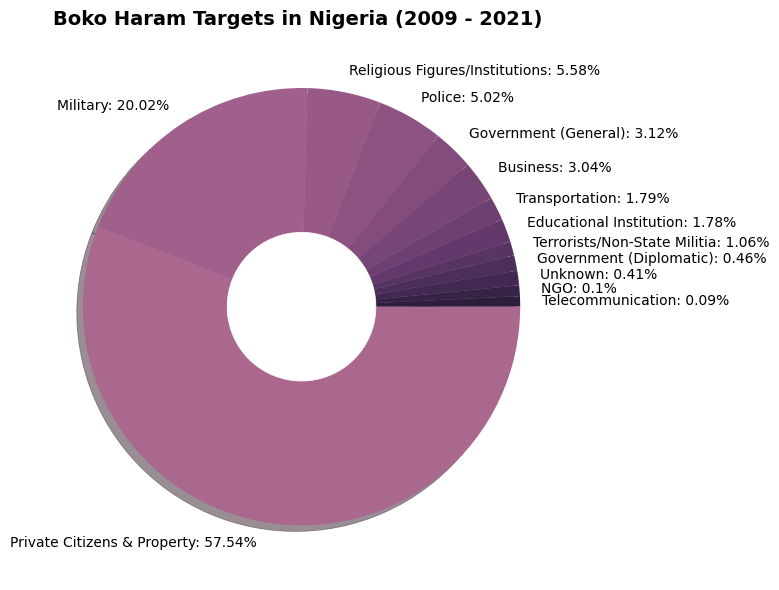

In [131]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot() 
ax.pie(x=nigeria_targets['total_fatalities'].apply(lambda row: row + 150 if row < 100 else row ).tolist(), 
       labels=nigeria_targets.apply(lambda row: "%s: %s%%" % (row['targtype1_txt'], row['percentage']), axis=1  ).tolist(), 
       colors=sns.palettes.cubehelix_palette(n_colors=25)[::-1],
       shadow=True, 
      )
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), radius=0.34, color='white' ))
ax.set_title("Boko Haram Targets in Nigeria (2009 - 2021) ", fontweight='bold', fontsize=14)
plt.tight_layout() 

#### **Boko Haram violence against civilians in Nigeria** 
- Armed assult using firearms againts `civilians` 

In [138]:
bh_civilians: 'DataFrame' = pd.DataFrame([ item.asDict() for item in nigeria_bh_df.filter("targtype1_txt == 'Private Citizens & Property' and success == 1").select('iyear', 'imonth', 'iday', 'nkill' , 'weaptype1_txt', 'attacktype1_txt').collect() ] )
bh_civilians = bh_civilians.replace({np.nan:0})
bh_civilians['incident_date'] = pd.to_datetime( bh_civilians.apply(lambda row: "%s-%s-%s" % (row['iyear'], row['imonth'], row['iday']), axis=1) )

In [192]:
pd.DataFrame( bh_civilians.groupby(['attacktype1_txt','weaptype1_txt'])['nkill'].sum().sort_values(ascending=False) ).astype(int)

nkill
attacktype1_txt                     weaptype1_txt       
Armed Assault                       Firearms        4876
Bombing/Explosion                   Explosives      2478
Armed Assault                       Explosives      2333
Hostage Taking (Kidnapping)         Firearms         741
Unknown                             Unknown          420
Hostage Taking (Kidnapping)         Explosives       288
                                    Melee            186
Hostage Taking (Barricade Incident) Firearms         166
Hostage Taking (Kidnapping)         Incendiary       103
Armed Assault                       Melee             54
Hostage Taking (Kidnapping)         Unknown           53
Armed Assault                       Incendiary        44
Facility/Infrastructure Attack      Incendiary        31
Assassination                       Firearms          30
Facility/Infrastructure Attack      Firearms          24
Assassination                       Explosives        14
Facility/Infrastructure Attack      Unknown           12
Assassination                       Unknown            1

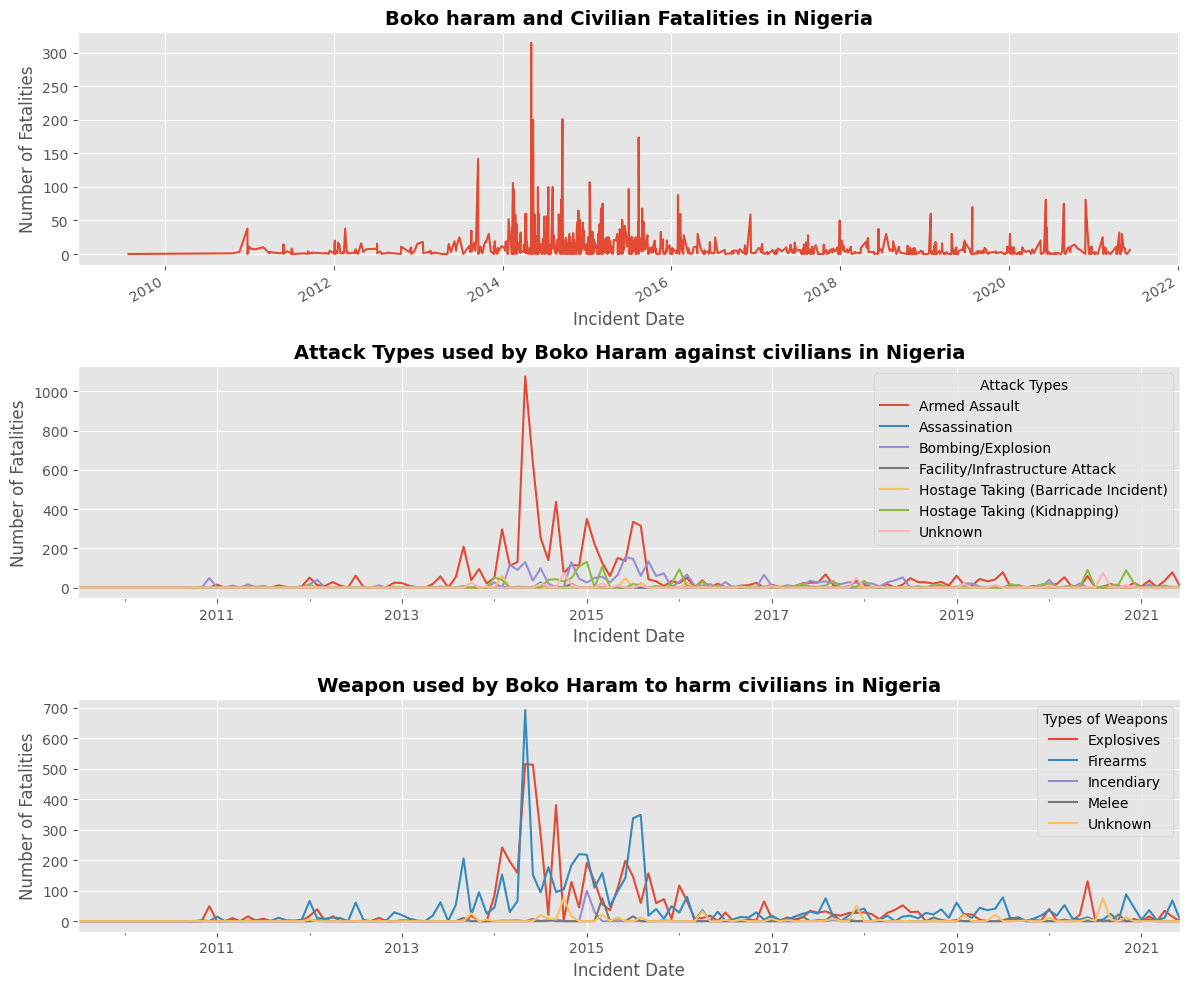

In [184]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(3,1,1)
bh_civilians.set_index('incident_date')['nkill'].plot(ax=ax)
ax.set_title("Boko haram and Civilian Fatalities in Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities")
ax.set_xlabel("Incident Date")

ax = fig.add_subplot(3,1,2)
bh_civilians.groupby(['incident_date','attacktype1_txt'])['nkill'].sum().unstack('attacktype1_txt').resample("M").sum().round().replace({np.nan:0}).astype(int).plot(ax=ax)
ax.legend(title="Attack Types")
ax.set_title("Attack Types used by Boko Haram against civilians in Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities")
ax.set_xlabel("Incident Date")

ax = fig.add_subplot(3,1,3)
pd.pivot_table(data=bh_civilians, columns=['weaptype1_txt'], index=['incident_date'], values='nkill', aggfunc='sum' ).resample('M').sum().interpolate().replace({np.nan: 0}).astype(int).sort_index().plot(ax=ax)  
ax.set_title("Weapon used by Boko Haram to harm civilians in Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities")
ax.set_xlabel("Incident Date")
ax.legend(title="Types of Weapons", fancybox=True)

plt.tight_layout() # spikes in BH activities: 2013 - late 2016 

#### **Boko Haram Bombing/Explosion Target Locations in Nigeria** 

In [73]:
bh_bombing: 'DataFrame' = nigeria_bh_df.filter(" attacktype1_txt == 'Bombing/Explosion'")
bh_bombing = bh_bombing.withColumnRenamed('success', 'outcome')
bh_bombing_events: 'DataFrame' = pd.DataFrame([ item.asDict() for item in bh_bombing.select('iyear', 'imonth', 'iday', 'outcome', 'nkill', 'nwound', 'weaptype1_txt', 'weapsubtype1_txt', 'targtype1_txt', 'targsubtype1_txt', 'longitude', 'latitude', 'addnotes' ).collect() ])

bh_bombing_events['nkill'] = bh_bombing_events['nkill'].replace({np.nan:0}).astype(int)
bh_bombing_events['nwound'] = bh_bombing_events['nwound'].replace({np.nan:0}).astype(float)

bh_bombing_events['outcome'] = bh_bombing_events['outcome'].replace({'1': 'Successful', '0':'Failed'})
bh_bombing_events['incident_date'] = pd.to_datetime( bh_bombing_events.apply(lambda row: "%s-%s-%s" % (row['iyear'], row['imonth'], row['iday']), axis=1 ) )

### **BH Private Citizens & Property Targets**

### **BH Military Targets**
- **Types of Explosives/IED used by BH**
1. By Trigger Meachanism (Radio/Mobile Phone/Wire)
2. VBEID: (Bombing method employeed by `ISIS`). VBEIDs can create additional sharpnel through the destruction of the vehicle itself and use vehicle fuel as an `incendiary weapon`.
3. Suicide

- **Historical Use of IED by Boko Haram**
1. **April 21, 2017**: Three soldiers attached to the `82 Division Task Force Battalion` of the Nigerian Army were on patrol along the `Ngoshe-Pulka Road` in Borno State when the IED planted by Boko Haram insurgents exploded, killing the three soldiers and injuring two others.
2. Boko Haram IED factory at Gombole village in Konduga Local Government Area of Borno has been destroyed by the `103 Battalion` Nigerian Troops (Operation Lafiya Dole) [10].

- **Nigeria Land Forces & AirPower (As of 2024) [11]**
1. **Self-Propelled Artillery Readiness**: 19 Units
2. **Towed Artillery Readiness**: 203 Units
3. **Multiple Launch Rocket Projectors (MLRS) Readiness**: 22 Units
4. **Helicopters Readiness**: 32 Units
5. **Fighter Aircrafts Readiness**: 8 Units

In [58]:
pd.DataFrame( bh_bombing_events.query("targtype1_txt == 'Military' ").groupby(['targsubtype1_txt', 'weapsubtype1_txt'])['nkill'].sum().sort_values(ascending=False) ).rename({'nkill': 'total_fatalities'}, axis=1)
# VBIED: (Civilian & Military Targets) 2015 - 2016 peak_violence 

total_fatalities
targsubtype1_txt                                        weapsubtype1_txt                                           
Military Barracks/Base/Headquarters/Checkpost           Unknown Explosive Type                                  155
Military Checkpoint                                     Vehicle                                                 112
Military Unit/Patrol/Convoy                             Unknown Explosive Type                                   84
Military Checkpoint                                     Suicide (carried bodily by human being)                  70
Military Barracks/Base/Headquarters/Checkpost           Suicide (carried bodily by human being)                  67
                                                        Vehicle                                                  63
Military Unit/Patrol/Convoy                             Vehicle                                                  61
Military Personnel (soldiers, troops, officers, forces) Suicide (carried bodily by human being)                  54
Military Transportation/Vehicle (excluding convoys)     Vehicle                                                  50
Military Personnel (soldiers, troops, officers, forces) Unknown Explosive Type                                   41
Military Barracks/Base/Headquarters/Checkpost           Other Explosive Type                                     39
Military Unit/Patrol/Convoy                             Landmine                                                 38
Military Transportation/Vehicle (excluding convoys)     Landmine                                                 27
Military Personnel (soldiers, troops, officers, forces) Vehicle                                                  22
                                                        Projectile (rockets, mortars, RPGs, etc.)                17
Military Unit/Patrol/Convoy                             Projectile (rockets, mortars, RPGs, etc.)                14
Military Barracks/Base/Headquarters/Checkpost           Grenade                                                  14
Military Checkpoint                                     Remote Trigger                                           14
Military Transportation/Vehicle (excluding convoys)     Unknown Explosive Type                                   10
Military Personnel (soldiers, troops, officers, forces) Landmine                                                  9
Military Unit/Patrol/Convoy                             Suicide (carried bodily by human being)                   8
Paramilitary                                            Vehicle                                                   4
Military Unit/Patrol/Convoy                             Explosive                                                 2
Paramilitary                                            Suicide (carried bodily by human being)                   2
                                                        Unknown Explosive Type                                    2
Military Unit/Patrol/Convoy                             Other Explosive Type                                      0
                                                        Remote Trigger                                            0

In [159]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(1,2,1)
bh_bombing_events.query("targtype1_txt == 'Military' and outcome == 'Successful' ").set_index('incident_date')['nkill'].plot(ax=ax) # successful suicide attack by BH 
ax.set_title("Trends in Military Bombing Fatalities in Nigeria by Boko Haram", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities")

ax = fig.add_subplot(1,2,2)
bh_bombing_events.query("targtype1_txt == 'Military' and outcome == 'Successful' and targsubtype1_txt == 'Military Barracks/Base/Headquarters/Checkpost' ").set_index('incident_date')['nkill'].plot(ax=ax)
ax.set_title("BH Military Barracks/Base/Headquarters/Checkpost Bombing in Nigeria", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Fatalities")

plt.tight_layout() 

#### **BH Military Bombing Target Locations in Nigeria**

In [146]:
nigeria_military_targets: 'DataFrame' = bh_bombing_events.query("targtype1_txt == 'Military' and outcome == 'Successful' ")
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,2,1)
gdf = gp.GeoDataFrame( nigeria_military_targets, geometry=gp.points_from_xy(nigeria_military_targets.longitude, nigeria_military_targets.latitude) ) 
nigeria_map: 'DataFrame' = gp.read_file(gp.datasets.get_path(gp.datasets.available[0])).query("continent == 'Africa'")
nigeria_map [nigeria_map['name'].isin([ 'Niger', 'Nigeria' ])].plot(ax=ax, ec='k', alpha=0.8, color='white', cmap=ListedColormap(sns.crayon_palette(MAP_COLOR)))
gdf.plot(ax=ax, markersize='nkill', ec='k' )
ax.set_title("BH Military Bombing Target Locations in Nigeria", fontweight='bold', fontsize=14)

ax.axis('off')
ax.grid(True)

ax = fig.add_subplot(1,2,2)
nm_trgtypes: 'Series' = nigeria_military_targets.groupby(['targsubtype1_txt'])['nkill'].sum().sort_values()
ax.pie(x=nm_trgtypes.tolist(), labels=pd.DataFrame( [ {'target_type': k, 'freq': v} for k,v in nm_trgtypes.to_dict().items() ] ).apply(lambda row: "%s: %s %%" % (row['target_type'], round( (row['freq'] / nm_trgtypes.sum()) * 100,2) ) , axis=1).tolist() )
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), radius=0.34, color='white' ))
ax.set_title("Boko Haram Military Targets", fontweight='bold', fontsize=14)
plt.tight_layout() 

#### **Military Target Locationss targeted by Boko Haram in Borno, Nigeria**

In [176]:
bh_df = bh_df.withColumn('nkill', f.col('nkill').cast('integer').alias('nkill') )
bh_df.filter("targtype1_txt == 'Military' and success == 1  and targsubtype1_txt == 'Military Barracks/Base/Headquarters/Checkpost' and provstate == 'Borno' ").groupBy('city').agg(f.sum('nkill').alias('total_fatalities') ).na.fill(0).orderBy('total_fatalities', ascending=False).show(25)

+---------+----------------+
|     city|total_fatalities|
+---------+----------------+
|Maiduguri|             272|
|   Mitile|             207|
|   Damboa|             141|
| Tungushe|             108|
|     Bama|              86|
|     Baga|              58|
|     Zaro|              48|
|  Monguno|              40|
|Bulabulin|              40|
|  Gajiram|              35|
|   Mainok|              33|
|  Damasak|              32|
| Magumeri|              30|
| Kangarwa|              27|
|New Marte|              25|
|    Gubio|              23|
|  Garunda|              18|
|   Abadam|              17|
|  Yamteke|              16|
|    Marte|              15|
|   Jakana|              14|
|Gajiganna|              14|
|Bula Yobe|              14|
|   Kukawa|              11|
|     Rann|              10|
+---------+----------------+
only showing top 25 rows



In [37]:
# TODO: election - gov workers targeted (hostage)
notes: str = boko_haram['notes'].iloc[0]
resp: Dict = comprehend.detect_entities(Text=notes, LanguageCode='en')
resp

### **Islamic State Area of Operations in `West Africa`** 
- The ISIS group primarily operating in northeastern Nigeria, and claimed operational expansion into central and southwestern Nigerian states. 
- The ISIS group also conducts operations throughout the Lake Chad Basin region of Cameroon, Chad, Niger, and Nigeria.


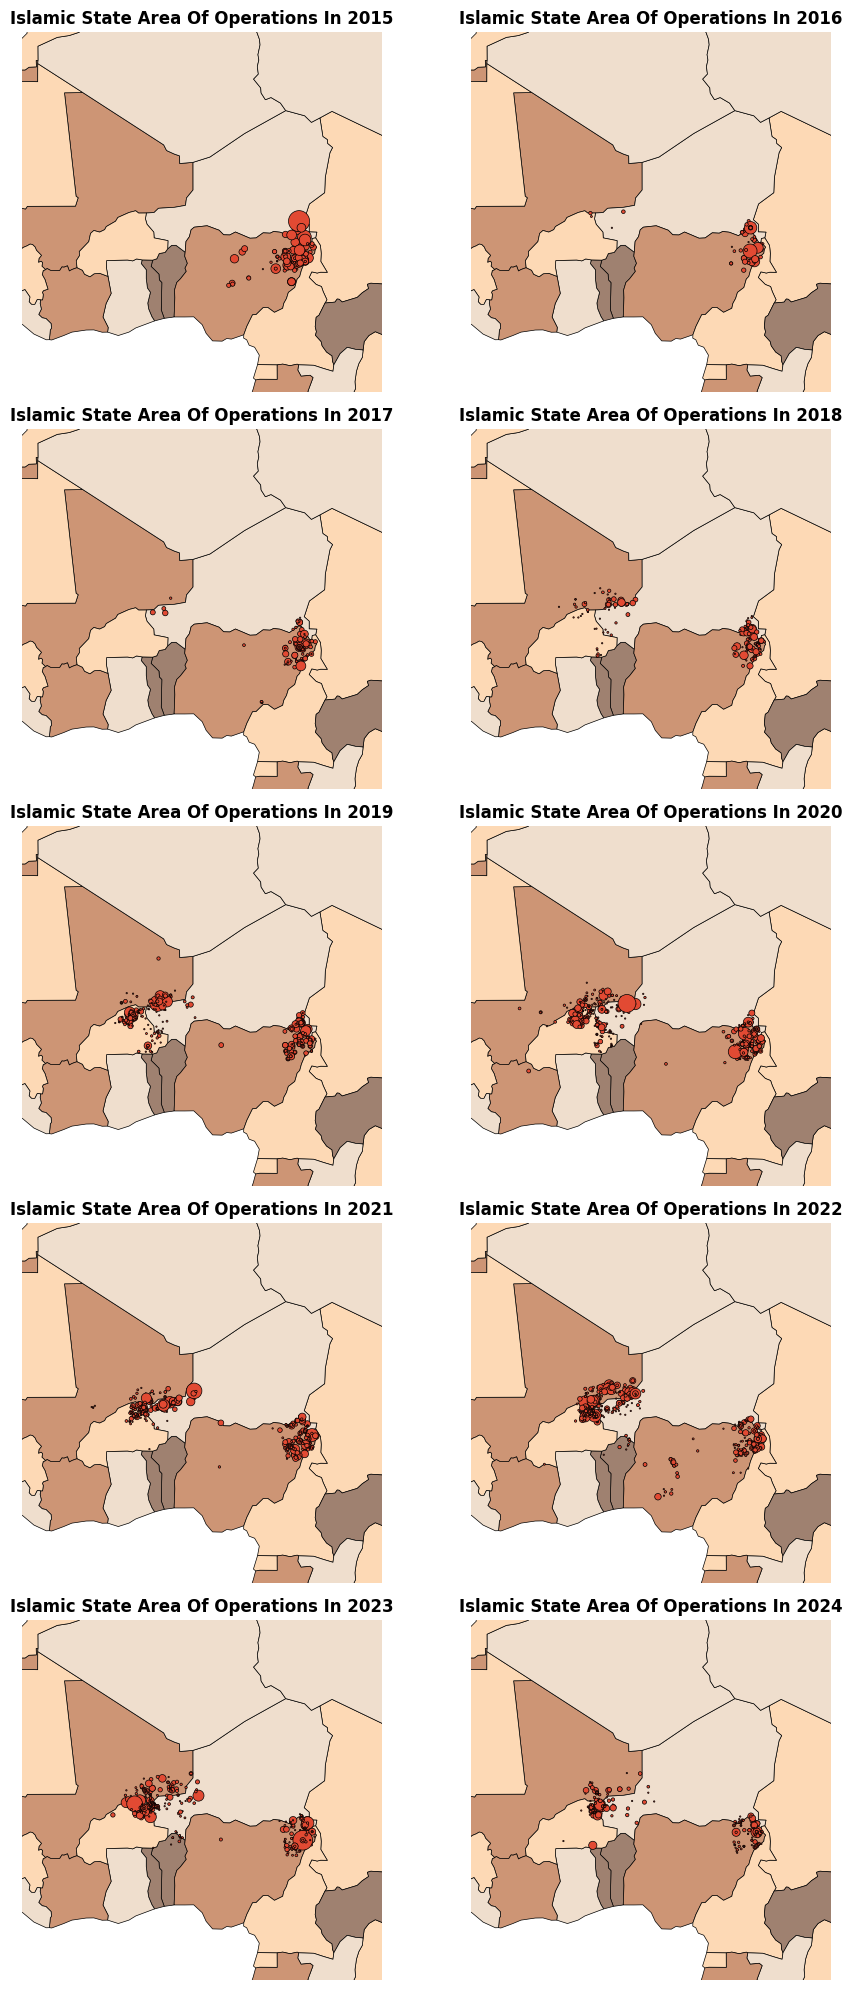

In [133]:
plt.rcParams['figure.figsize'] = (10,20)
fig = plt.figure()
for index,year in enumerate(islamic_state_af['year'].sort_values().unique(), 1):
    ax = fig.add_subplot(5,2, index) 
    curr_df: 'DataFrame' = islamic_state_af.query(f"year == {year}") 
    gdf: 'GeoDataFrame'  = gp.GeoDataFrame(data=curr_df, geometry=gp.points_from_xy(x=curr_df.longitude, y=curr_df.latitude))
    world_map: 'GeoDataFrame' = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
    
    ax1: 'axis' = world_map.query("continent == 'Africa' " ).plot(color='white', ec='k', ax=ax, cmap=ListedColormap(sns.crayon_palette( sns.crayons.keys())[:3] + [ sns.crayon_palette( sns.crayons.keys())[7] ]) )
    ax.axis('off') 
    ax.set_xlim([-10, 20])
    ax.set_ylim([0, 30])
    
    gdf.plot(ax=ax1, markersize='fatalities', ec='k')
    ax.set_title(f"Islamic State Area of Operations in {year}".title(), fontweight='bold', fontsize=12)

plt.tight_layout() 

In [60]:
islamic_state_af.query("disorder_type == 'Political violence' ")['notes'].apply(lambda row: row if 'elect' in row.lower() else np.nan ).dropna()

13175    On 6 August 2023, overnight, presumed JNIM or IS Sahel kidnapped the locally elected village chief of Kangara and one of his councilors before killing them (slitting their throats) in Sakawan Tedj...
17876    On 14 March 2023, overnight, presumed JNIM or IS Sahel shot and killed a man (a local elected official, according to one source) in his house before leaving the village by motorcycle in Mamassi Pe...
28275     On 6 May 2022, ISWAP/ Boko Haram militants claimed the detonation of an explosive device targeted at an electricity tower on the road linking Azare and Jamaare (Jamaare, Bauchi). Casualties unknown.
40845    On 27 February 2021, the explosion of a device planted by Boko Haram in Mainok (Kaga LGA, Borno) led to the injury of two engineers from the Transmission Company of Nigeria (TCN) and Yola Electric...
41010    On 21 February 2021, ISWAP militant attacked electoral workers in Garin Dogo (Diffa, Diffa). One civilian was killed and at least seven others wounded. ISW

In [81]:
pd.Series( africa_df['assoc_actor_1'].astype(str).unique()).apply(lambda row: row if 'boko haram' in row.lower() else np.nan).dropna().tolist() 

['Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad; Prisoners (Nigeria)',
 'Former Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
 'Former Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
 'Former Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
 'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
 'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad; Prisoners (Niger)',
 'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad']

# **References**
1. https://www.dni.gov/nctc/ftos/al_shabaab_fto.html
2. 12. https://www.dni.gov/nctc/methods.html#sarin
3. https://www.cnn.com/2014/06/09/africa/boko-haram-fast-facts
4. https://www.un.org/securitycouncil/ctc/content/foreign-terrorist-fighters
5. https://www.dni.gov/nctc/ftos/jnim_fto.html
6. https://www.dni.gov/nctc/ftos/isis_west_africa_fto.html
7. Kara, Siddartah. Sex Trafficking: Inside the Business of Modern Slavery. New York: Columbia University Press, 2009, p. 12
8. Jawad Al-Tamimi, A., Archive of Islamic State Administrative Documents, Pundicity, 11 January 2016, available at:
http://www.aymennjawad.org/2016/01/archive-of-islamic-state-administrative-documents-1.
9. United Nations Human Rights Council, They came to destroy: ISIS Crimes Against the Yazidi, June 2016, p. 13.
10.  Centre for Financial Crime & Security Studies (2015), Boko Haram finances, www.cfcs.london/analysis/boko-haram-finances/
11. https://punchng.com/troops-destroy-ied-factory-rescue-10-hostages-in-borno/
12. https://www.globalfirepower.com/country-military-strength-detail.php?country_id=nigeria